In [2]:
import dgl
import numpy as np
import torch
import networkx as nx

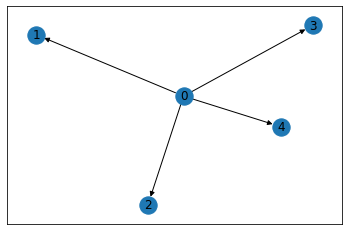

In [3]:
g = dgl.graph(([0,0,0,0], [1,2,3,4]), num_nodes=5)

gx = dgl.to_networkx(g)
nx.draw_networkx(gx)


In [4]:
g.ndata['value']  = torch.randn(5,3) #3d feature for node
g.edata['weight'] = torch.randn(4,4) #4d feature for edges

print(g.edata['weight']) # 4 edge -> 4 righe
print(g.ndata['value'])  # 5 nodi -> 5 righe


tensor([[ 0.1591,  0.8320,  0.0411,  0.4868],
        [ 0.4916,  0.5492, -1.6109,  0.5430],
        [ 0.0994, -0.3845, -0.1712, -0.0498],
        [-0.0559, -0.9447,  0.0568,  0.0104]])
tensor([[ 1.0258,  0.1280, -1.0836],
        [ 1.9310, -1.8037,  0.8258],
        [-1.8735,  0.2862,  1.0056],
        [ 0.2809, -0.5855,  1.2352],
        [-0.1694,  0.7289, -0.6440]])


DGL graph


In [5]:
G = dgl.DGLGraph()
G.add_nodes(3)
G.add_edges([1,2,3],1)
G

C:\Users\Pietro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


Graph(num_nodes=4, num_edges=3,
      ndata_schemes={}
      edata_schemes={})

In [6]:
graph = dgl.DGLGraph()

n = 10 # number of particles per jet
g.add_nodes(n)

src = []
dst = []
for i in range(n):
    for j in range(n):
        src.append(i)
        dst.append(j)

graph.add_edges(src, dst)


In [7]:
print(graph.num_nodes())
print(graph.num_edges())

10
100


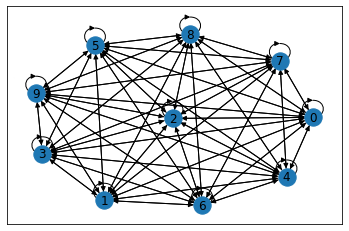

In [8]:
gx = dgl.to_networkx(graph)
nx.draw_networkx(gx)

In [9]:
node_feat = torch.randn(n,3)
graph.ndata['feat'] = node_feat
graph.ndata

{'feat': tensor([[ 0.2121,  0.7036, -1.0082],
        [ 0.4084, -0.5346,  0.0254],
        [-0.1559, -0.9799,  1.6659],
        [ 1.4244, -0.4828,  0.6009],
        [-1.7415, -0.8228,  0.4220],
        [ 1.6095,  0.2727, -0.2991],
        [-1.1411,  0.0880,  0.0997],
        [ 0.2859, -0.6550, -0.9399],
        [-0.3427, -0.0780, -0.1561],
        [ 0.4898,  1.0353, -0.6060]])}

In [10]:
edge_feat = torch.randn(n**2, 3)
print(edge_feat.shape)

graph.edata['edge_feat'] = edge_feat
# graph.edata

torch.Size([100, 3])


In [11]:
def build_graph(jet):
    """return a fully connected graph: 
        - n nodes -> n particles
        - n**2 edges -> each p is connected to all the others"""
    g = dgl.graph()
    n = len(jet)
    g.add_nodes(n)
    
    src = []; dst = []
    for i in range(n):
        for j in range(n):
            src.append(i)
            dst.append(j)

    graph.add_edges(src, dst)

    node_feat = jet # should be a tensor of shape [n, 5] where 5 are the features of each particle
    edge_feat = jet*jet # should be tensor of shape [n**2, 6 ]
    # the first n rows refer to the edges between the first particle and the other n ones

    graph.ndata['feat'] = node_feat
    graph.edata['edge_feat'] = edge_feat

    return g



## Simulated Graph
50 particelle, 7 features per particle, each node is connected to all the others so n**2 edges, each edge has 3 different features

In [43]:
n = 50 
src = []; dst = []
for i in range(n):
    for j in range(n):
        src.append(i)
        dst.append(j)

g = dgl.graph((src, dst))

nodes = torch.randn((n, 7))
edges = torch.randn((n**2, 3))

g.ndata['feat'] = nodes
g.edata['edge_feat'] = edges


## Decoder

In [44]:
from torch import nn
from dgl.nn import NNConv, EdgeConv

In [72]:
def MLP(efeat, ch=[256,128,64,32]):

    mlp = nn.Sequential(
        nn.Linear(3, ch[0]),
        nn.Dropout(0.2),
        nn.ReLU(),
        
        nn.Linear(ch[0],ch[1]),
        nn.Dropout(0.2),
        nn.ReLU(),
        
        nn.Linear(ch[1],ch[2]),
        nn.Dropout(0.2),
        nn.ReLU(),

        nn.Linear(ch[2], ch[3]),
        nn.Dropout(0.2),
        nn.ReLU(),

        nn.Linear(ch[3], 7*128),
        nn.Sigmoid()
    )
    
    return mlp(efeat)

In [74]:
conv = NNConv(7, 128, MLP)
res = conv(g, nodes, edges)
res.shape

torch.Size([50, 128])

In [32]:
class Encoder(nn.Module):
    
    def __init__(self, graph, latent_space_dim, ch=[256,128,64,32]):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(3, ch[0]),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(ch[0],ch[1]),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(ch[1],ch[2]),
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(ch[2], ch[3]),
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(ch[3], 7*128),
            nn.Sigmoid()
            )
        
        self.conv = nn.Sequential(
            NNConv(
                in_feats  = 7,  # number of node features
                out_feats = 128, # output number of node features
                edge_func = self.mlp),
            EdgeConv(128, 64),
            EdgeConv(64, 32),
            EdgeConv(32, latent_space_dim)
        )

    def forward(self, graph):
        x = self.conv(graph, graph.ndata, graph.edata)
        return x
    

In [33]:
class Decoder(nn.Module):
    
    def __init__(self, graph, latent_space_dim):
        super().__init__()
        
        self.node_reconstruct = nn.Sequential(
            EdgeConv(latent_space_dim, 32),
            EdgeConv(32, 64),
            EdgeConv(64, 128),
            EdgeConv(128, 7))# output are the reconstructed node features

        self.edge_reconstruct = nn.Sequential(
            EdgeConv(latent_space_dim, 32),
            EdgeConv(32, 64),
            EdgeConv(64, 128),
            EdgeConv(128, 32),
            EdgeConv(32,16),
            EdgeConv(16,8)
        )

    def forward(self, graph):
        # node reconstruction
        n = self.node_reconstruct(graph, graph.ndata, graph.edata)
        
        # edges reconstruction
        e1 = self.edge_reconstruct(graph, graph.ndata, graph.edata)
        e2 = self.edge_reconstruct(graph, graph.ndata, graph.edata)
        e3 = self.edge_reconstruct(graph, graph.ndata, graph.edata)

        # inner product o matmul?
        e1 = torch.inner(e1, e1)  #their elements are A_{ij}
        e2 = torch.inner(e2, e2) 
        e3 = torch.inner(e3, e3)

        return n, e1, e2, e3
    

In [34]:
### Initialize the two networks
encoded_space_dim = 6
encoder = Encoder(graph=g, latent_space_dim=encoded_space_dim)
decoder = Decoder(graph=g, latent_space_dim=encoded_space_dim)

In [36]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
print(encoder.to(device))
print(decoder.to(device))

Selected device: cpu
Encoder(
  (conv): Sequential(
    (0): NNConv()
    (1): EdgeConv(
      (theta): Linear(in_features=128, out_features=64, bias=True)
      (phi): Linear(in_features=128, out_features=64, bias=True)
    )
    (2): EdgeConv(
      (theta): Linear(in_features=64, out_features=32, bias=True)
      (phi): Linear(in_features=64, out_features=32, bias=True)
    )
    (3): EdgeConv(
      (theta): Linear(in_features=32, out_features=6, bias=True)
      (phi): Linear(in_features=32, out_features=6, bias=True)
    )
  )
)
Decoder(
  (node_reconstruct): Sequential(
    (0): EdgeConv(
      (theta): Linear(in_features=6, out_features=32, bias=True)
      (phi): Linear(in_features=6, out_features=32, bias=True)
    )
    (1): EdgeConv(
      (theta): Linear(in_features=32, out_features=64, bias=True)
      (phi): Linear(in_features=32, out_features=64, bias=True)
    )
    (2): EdgeConv(
      (theta): Linear(in_features=64, out_features=128, bias=True)
      (phi): Linear(in

## Learning Rate and Loss customize 

In [76]:
a = (1,2,3)
a[1]

2

In [75]:
def custom_loss(pred, real):
    """ pred and real are two tuples which contains:
    real: real nodes and edges
    real: real nodes and edges"""

    # regularization parameters    
    l_node = 0.3
    l_edge = 1
    
    def node_loss(real_node, pred_node):
        loss_fn = torch.nn.MSELoss()
        return torch.sqrt(loss_fn(pred_node, real_node))

    def edge_loss(real_A, pred_A1, pred_A2, pred_A3):
        """Three input prediction matrices"""
        loss_fn = torch.nn.MSELoss()
        l1 = torch.sqrt(loss_fn(pred_A1, real_A))
        l2 = torch.sqrt(loss_fn(pred_A2, real_A))
        l3 = torch.sqrt(loss_fn(pred_A3, real_A))

        return l1 + l2 + l3

    return l_node * node_loss(real[0],pred[0]) + l_edge * edge_loss(real[1],pred[1],pred[2],pred[3])


In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
loss_fn = custom_loss()
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = Adam(params_to_optimize, lr=lr)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

"""
usando questo bisogna fare scheduler.step(val_loss) alla fine di un epoca
"""
lr_scheduler = ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor=0.5,
    patience=5,
    cooldown=5,
    min_lr=10e-8 # this should be the minimum value of the lr at which we stop the training
    )

## training and validate function

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()

    # abbiamo già definito l'optimizer nella cella precedente
    
    losses = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        
        batch = batch.to(device)
        #encode
        y_encoder_pred = encoder(batch)
        #decode
        y_decoder_pred = decoder(y_encoder_pred)

        loss = loss_fn(y_decoder_pred, batch)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        losses.append(loss.detach().cpu().numpy())
    losses = np.mean(losses)
    return losses

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()

    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
# train the model
epoch = 0
while(True):
    # train for one epoch
    print('EPOCH %d' % (epoch + 1))

    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    print(f'TRAIN - EPOCH {epoch+1} - loss: {train_loss}')

    # evaluate the model
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print(f'VALIDATION - EPOCH {epoch+1} - loss: {val_loss}\n')

    # schedule the learning rate
    epoch +=1
    lr_scheduler.step(val_loss)

    if optimizer.param_groups[0]['lr'] < 1e-8:
        break